In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from matplotlib_setup import *
#print(mpl.rcParams)
mpl.rc('figure', figsize=figure_size)
mpl.rc('legend', handlelength = 1)
mpl.rc('legend', frameon = False)
mpl.rc('lines', markersize = 5)

from pyPLBFGS import PLBFGS
from pyPLBFGS.goodies import ill_conditioned_problem
from scipy.sparse.linalg import LinearOperator
import matplotlib.pyplot as plt

import numpy as np

In [2]:
def solve(size, m, scaling):
    problem = ill_conditioned_problem(size, condition=True)
    plbfgs = PLBFGS(problem.fun, problem.grad, problem.M, m)
    lbfgs = PLBFGS(problem.fun, problem.grad,
                   LinearOperator((size, size), lambda x:x), m)
    tol =  1e-7

    search_position = np.zeros(size)

    legacy_result = lbfgs.solve(search_position, tol, scaling=scaling)
    if not legacy_result.success:
        raise Exception("regular LBFGS failes for size = {} with the following OptimizeResult:\n{}".format(size, legacy_result))
    error = np.linalg.norm(problem.solution - legacy_result["x"])
    # if not error < 100*np.sqrt(tol):
    #     raise Exception("regular LBFGS for size = {} failed: error = {}, tol = {}.".format(size, error, np.sqrt(tol)))

    result = plbfgs.solve(search_position, tol, scaling=scaling)
    error = np.linalg.norm(problem.solution - result["x"])
    # if not error < np.sqrt(tol):
    #     raise Exception("preconditioned LBFGS for size = {} failed: error = {}, tol = {}.".format(size, error, np.sqrt(tol)))

    return legacy_result, result

def scaling_comparison(size, m):
    problem = ill_conditioned_problem(size, condition=True)
    shanno = PLBFGS(problem.fun, problem.grad, problem.M, m)
    nocedal = PLBFGS(problem.fun, problem.grad, problem.M, m)
    tol =  1e-7

    search_position = np.zeros(size)

    nocedal_result = nocedal.solve(search_position, tol, scaling='Nocedal')
    if not nocedal_result.success:
        raise Exception(" nocedal scalingfails for size = {} with the following OptimizeResult:\n{}".format(size, nocedal_result))
    error = np.linalg.norm(problem.solution - nocedal_result["x"])
    # if not error < 100*np.sqrt(tol):
    #     raise Exception("regular LBFGS for size = {} failed: error = {}, tol = {}.".format(size, error, np.sqrt(tol)))

    shanno_result = shanno.solve(search_position, tol, scaling='Shanno')
    error = np.linalg.norm(problem.solution - shanno_result["x"])
    # if not error < np.sqrt(tol):
    #     raise Exception("preconditioned LBFGS for size = {} failed: error = {}, tol = {}.".format(size, error, np.sqrt(tol)))

    return nocedal_result, shanno_result


In [3]:

def visualize(sizes, memory, scaling="Nocedal"):
    bfevals = list()
    bgevals = list()
    bniters = list()
    pfevals = list()
    pgevals = list()
    pniters = list()


    for size in sizes:
        print(f"dealing with size = {size}")
        try:
            b, p = solve(size, memory, scaling)
        except Exception as err:
            raise Exception("for size = {},\ncaught error {}".format(size, err))
        bfevals.append(b["nfev"])
        bgevals.append(b["njev"])
        bniters.append(b["nit"])

        pfevals.append(p["nfev"])
        pgevals.append(p["njev"])
        pniters.append(p["nit"])
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.loglog(sizes, bfevals, "b--x", label="fun eval LBFGS")
    #ax.loglog(sizes, bgevals, "b-x", label="grad eval LBFGS")
    ax.loglog(sizes, bniters, "b-x", label="niter LBFGS")
    ax.loglog(sizes, pfevals, "r--+", label="fun eval PLBFGS")
    #ax.loglog(sizes, pgevals, "r-x", label="grad eval PLBFGS")
    ax.loglog(sizes, pniters, "r-+", label="niter PLBFGS")
    ax.legend()
    ax.grid(True)
    ax.set_ylabel("count (log scale)")
    ax.set_xlabel("system size (log scale)")
    fig.tight_layout()
    return fig

def visualize_scaling(sizes, memory):
    bfevals = list()
    bgevals = list()
    bniters = list()
    pfevals = list()
    pgevals = list()
    pniters = list()


    for size in sizes:
        print(f"dealing with size = {size}")
        try:
            b, p = scaling_comparison(size, memory)
        except Exception as err:
            raise Exception("for size = {},\ncaught error {}".format(size, err))
        bfevals.append(b["nfev"])
        bgevals.append(b["njev"])
        bniters.append(b["nit"])

        pfevals.append(p["nfev"])
        pgevals.append(p["njev"])
        pniters.append(p["nit"])
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.semilogx(sizes, bfevals, "b--x", label="fun eval Nocedal")
    #ax.semilogx(sizes, bgevals, "b-x", label="grad eval Nocedal")
    ax.semilogx(sizes, bniters, "b-x", label="niter Nocedal")
    ax.semilogx(sizes, pfevals, "r--+", label="fun eval Shanno")
    #ax.semilogx(sizes, pgevals, "r-x", label="grad eval Shanno")
    ax.semilogx(sizes, pniters, "r-+", label="niter Shanno")
    ax.legend()
    ax.grid(True)
    ax.set_ylabel("count (log scale)")
    ax.set_xlabel("system size (log scale)")
    fig.tight_layout()
    return fig



dealing with size = 8
dealing with size = 16
dealing with size = 32
dealing with size = 64


dealing with size = 128


dealing with size = 256


dealing with size = 512


dealing with size = 1024


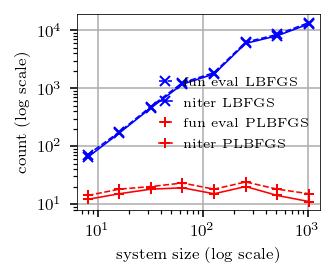

In [12]:
sizes = [8, 16, 32, 64, 128, 256, 512, 1024]
fig = visualize(sizes, 4)
fig.savefig("mem_04_scaling_yes.pdf")
fig.savefig("mem_04_scaling_yes.png", dpi=600)


dealing with size = 8
dealing with size = 16
dealing with size = 32
dealing with size = 64
dealing with size = 128
dealing with size = 256


dealing with size = 512


dealing with size = 1024


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


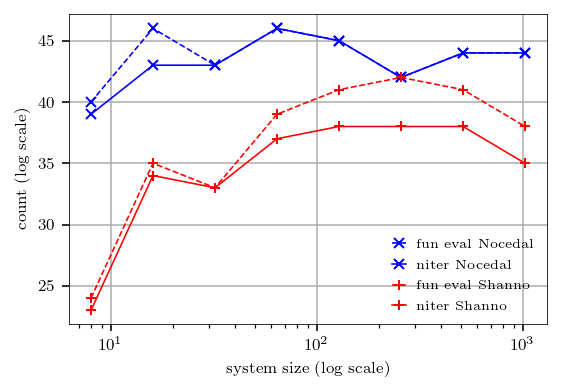

In [4]:
sizes = [8, 16, 32, 64, 128, 256, 512, 1024]
fig = visualize_scaling(sizes, 4)
fig.savefig("mem_04_scaling_comp.pdf")
fig.savefig("mem_04_scaling_comp.png", dpi=600)


dealing with size = 8
dealing with size = 16
dealing with size = 32
dealing with size = 64
dealing with size = 128
dealing with size = 256
dealing with size = 512


dealing with size = 1024


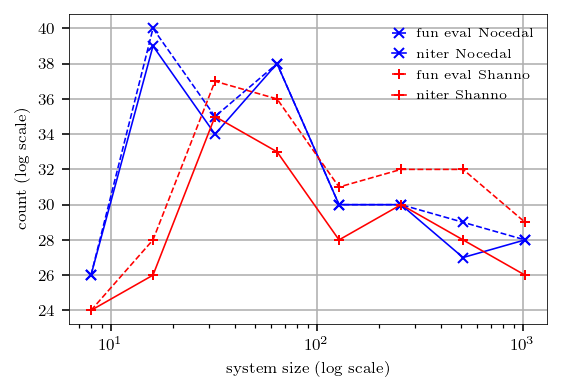

In [5]:
sizes = [8, 16, 32, 64, 128, 256, 512, 1024]
fig = visualize_scaling(sizes, 8)
fig.savefig("mem_08_scaling_comp.pdf")
fig.savefig("mem_08_scaling_comp.png", dpi=600)


dealing with size = 8
dealing with size = 16
dealing with size = 32
dealing with size = 64
dealing with size = 128
dealing with size = 256
dealing with size = 512


dealing with size = 1024


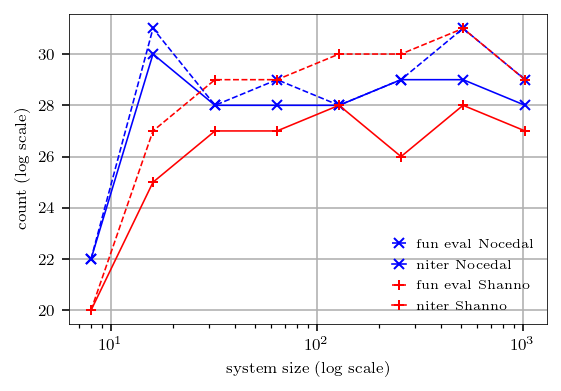

In [6]:
sizes = [8, 16, 32, 64, 128, 256, 512, 1024]
fig = visualize_scaling(sizes, 16)
fig.savefig("mem_16_scaling_comp.pdf")
fig.savefig("mem_16_scaling_comp.png", dpi=600)


dealing with size = 8
dealing with size = 16
dealing with size = 32
dealing with size = 64
dealing with size = 128


dealing with size = 256


dealing with size = 512


dealing with size = 1024


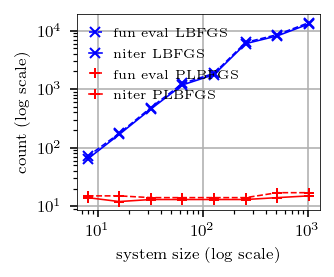

In [8]:
sizes = [8, 16, 32, 64, 128, 256, 512, 1024]
fig = visualize(sizes, 4, scaling="Shanno")
fig.savefig("mem_04_scaling_yes.pdf")
fig.savefig("mem_04_scaling_yes.png", dpi=600)


dealing with size = 8
dealing with size = 16
dealing with size = 32
dealing with size = 64
dealing with size = 128


dealing with size = 256


dealing with size = 512


dealing with size = 1024


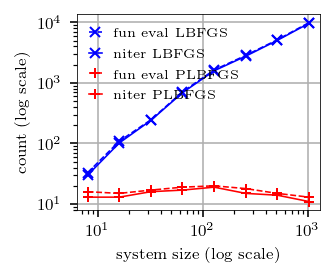

In [10]:
sizes = [8, 16, 32, 64, 128, 256, 512, 1024]
fig = visualize(sizes, 8)
fig.savefig("mem_08_scaling_nocedal.pdf")
fig.savefig("mem_08_scaling_nocedal.png", dpi=600)

dealing with size = 8
dealing with size = 16
dealing with size = 32
dealing with size = 64
dealing with size = 128


dealing with size = 256


dealing with size = 512


dealing with size = 1024


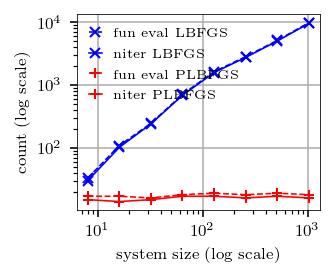

In [9]:
sizes = [8, 16, 32, 64, 128, 256, 512, 1024]
fig = visualize(sizes, 8, scaling="Shanno")
fig.savefig("mem_08_scaling_shanno.pdf")
fig.savefig("mem_08_scaling_shanno.png", dpi=600)

dealing with size = 8
dealing with size = 16
dealing with size = 32
dealing with size = 64
dealing with size = 128


dealing with size = 256


dealing with size = 512


dealing with size = 1024


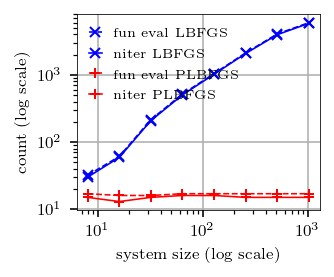

In [7]:
sizes = [8, 16, 32, 64, 128, 256, 512, 1024]
fig = visualize(sizes, 16)
fig.savefig("mem_16_scaling_yes.pdf")
fig.savefig("mem_16_scaling_yes.png", dpi=600)

dealing with size = 8
dealing with size = 16
dealing with size = 32
dealing with size = 64
dealing with size = 128


dealing with size = 256


dealing with size = 512


dealing with size = 1024


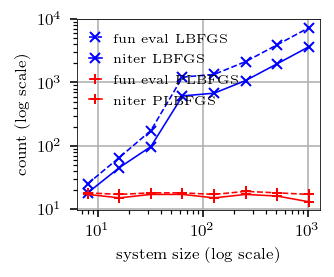

In [8]:
sizes = [8, 16, 32, 64, 128, 256, 512, 1024]
fig = visualize(sizes, 16, scaling=False)
fig.savefig("mem_16_scaling_no.pdf")
fig.savefig("mem_16_scaling_no.png", dpi=600)